# **Project 1 - Exploratory Data Analysis**

---
# **1. Assignment Tables**

  | Student ID  | Name                         | % of contribution | Task                                               |
  |-------------|------------------------------|-------------------|----------------------------------------------------|
  | 20127214    | Nguyễn Trương Minh Khôi      | 100               | Collecting data                                    |
  |             |                              |                   | Making question 3,6 + analyze + visualize          |
  |             |                              |                   |                                                    |
  | 20127613    | Phan Thanh Sang              | 100               | Collecting data                                    |
  |             |                              |                   | Making question 2,4 (Machine Learning) + analyze   |
  |             |                              |                   |                                     + visualize    |
  |             |                              |                   |                                                    |
  | 20127612    | Đỗ Khánh Sang                | 100               | Load data                                          |
  |             |                              |                   | Count number of rows and columns                   |
  |             |                              |                   | Check duplicate                                    |
  |             |                              |                   | Check Columns' Datatypes, adjust if needed         |
  |             |                              |                   | Making question 1,7 + analyze + visualize          |
  |             |                              |                   |                                                    |
  | 20127484    | Nguyễn Tư Duy                | 100               | Find out distribution of numeric data columns      |
  |             |                              |                   |      (missing percentage, min, max, median,...)    |
  |             |                              |                   | Find out distribution of non-numeric data columns  |       
  |             |                              |                   |          (missing percentage, number of values,    |
  |             |                              |                   |                                different value,..) |
  |             |                              |                   | Making question 5,8 + analyze + visualize          |
  |             |                              |                   |                                                    |
  | 20127560    | Phạm Trần Trung Lượng        | 100               | Remove rows containing missing values if available |
  |             |                              |                   | Remove data outliers if needed                     |
  |             |                              |                   | Normalize data (genre,...)                         |
  |             |                              |                   | Making question 9,10,11 (Machine Learning)         | 
  |             |                              |                   |                          + analyze + visualize     | 

In [1]:
## Libraries and Modules

from bs4 import BeautifulSoup
from selenium import webdriver

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
import copy
import time
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

---
# **2. Data Collection**

**Due to long running time, we have commented lines of data collection code.**

## **Explanation**

First of all, we create a list of keywords. And then for each keyword, we get 200 first results for playlist searching, and get links to those playlists. Finally, we write all these links to file playlist_link.txt.

In [2]:
# Get playlist links

def get_list_of_playlist_links(keywords):
    link = []
    driver = webdriver.Chrome()

    for k in keywords:
        url = f'https://soundcloud.com/search/sets?q={k}'
        driver.get(url)

        # scroll = 'window.scrollTo(0, document.body.scrollHeight);'
        for i in range(80):
            driver.execute_script("window.scrollBy(0, 300000);")
            time.sleep(0.5)
            
        page = BeautifulSoup(driver.page_source)
        find = page.find_all('a', class_ = 'sc-link-primary soundTitle__title sc-link-dark sc-text-h4')

        genre_link = [find[i]['href'] for i in range(len(find))]
        genre_link = ['https://soundcloud.com' + genre_link[i] for i in range(len(genre_link))]
        genre_link = genre_link[:200]
        print(len(genre_link))
        link.extend(genre_link)

        time.sleep(3)

    driver.quit()

    return link

keywords = ['indie', 'lofi', 'hiphop', 'edm', 'disco', 'rap', 'acoustic', 'folk', 'pop', 'rock']
# link = get_list_of_playlist_links(keywords)
# print(len(link))

# write_file = open('playlist_link.txt', 'w')

# for i in range(len(link)):
#     write_file.write(link[i] + '\n')

# write_file.close()

In [3]:
# Intialize variables

tracks_link = []
users_link = []

users_id = dict()       # dictionary contain corresponding id for users
tracks_id = dict()      # dictionary contain corresponding id for tracks
playlists_id = dict()   # dictionary contain corresponding id for playlists

number = 2000           # number of rows to get

- Traverse through each playlist link in file playlist_link.txt and get its information. While getting information of each feature, get link of user posting the playlist, as well as 10 first user links and track links of the current playlist, and assign id for each link simultaneously. Then store these links in lists and write to files user_link.txt, track_link.txt, playlist_id.json, user_id.json and track_id.json

- information of playlist:
  | Fields            | Description                                                                   |
  |-------------------|-------------------------------------------------------------------------------|
  |`ID`               | ID of playlist (each playlist has a unique ID)                                |
  |`Name`             | Name of playlist                                                              |
  |`Poster`           | User who posted playlist                                                      |
  |`NumTracks`        | Total tracks in playlist                                                      |
  |`TopTracks`        | List contain top 10 tracks in playlist                                        |
  |`Likes`            | Number of likes                                                               |
  |`Reposts`          | Number of reposts                                                             |
  |`PostedTime`       | Posted time (ex: 5 March 2017)                                                |
  |`Genre`            | Genre of playlist                                                             |
  |`Length`           | Duration time of playlist                                                     |


In [4]:
# Get playlists and write to file playlist.csv

def get_playlists(users_id, tracks_id, playlists_id, tracks_link, users_link):
    file = open('playlist_link.txt', 'r')
    playlists_link = [line.strip() for line in file.readlines()]
    file.close()

    users_id_order = 1
    tracks_id_order = 1
    playlists_id_order = 1
    
    # Get all playlists genre 
    genre = ''
    for kw in keywords:
        genre = genre + (kw + ',') * 200
    genre = genre.split(',')[:-1]
    
    keys = ['ID', 'Name', 'Poster', 'NumTracks', 'TopTracks', 'Likes', 'Reposts', 'PostedTime', 'Genre', 'Length']
    values = [[], [], [], [], [], [], [], [], genre[:number], []]
    
    # Get playlists id
    current_playlists_id = []
    for playlist_link in playlists_link:
        if playlist_link not in playlists_id.keys():
            playlists_id[playlist_link] = 'P' + str(playlists_id_order)
            current_playlists_id.append(playlists_id[playlist_link])
            playlists_id_order += 1
        else:
            current_playlists_id.append(playlists_id[playlist_link])
    values[0] = current_playlists_id[:number]
    
    driver = webdriver.Chrome()

    for i in range(number):
        url = playlists_link[i]

        r = driver.get(url)

        time.sleep(2)
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(2)
        
        source = BeautifulSoup(driver.page_source, features='html.parser')
        
        # Get Name
        find_name = source.find('h1', class_ = 
                                'soundTitle__title sc-font g-type-shrinkwrap-inline g-type-shrinkwrap-large-primary theme-dark')
        if str(find_name) != 'None':
            name = find_name.get_text().strip()
            values[1].append(name)
        else:
            values[1].append('None')

        # Get Users link
        current_user_link = []
            #---Get Poster---#
        find_poster = source.find('a', class_ = 'sc-link-secondary')
        poster = ''
        if str(find_poster) != 'None':
            poster = 'https://soundcloud.com' + find_poster['href']
            current_user_link.append(poster)
            #---Get Poster---#

        find_users = source.find_all('a', class_ = 'trackItem__username sc-link-light sc-link-secondary sc-mr-0.5x')
        if str(find_users) != 'None':
            current_user_link.extend(['https://soundcloud.com' + find_users[i]['href'] for i in range(len(find_users))])
            if len(current_user_link) > 11:
                current_user_link = current_user_link[:11]
            
            # assign id for users
            for user_link in current_user_link:
                if user_link not in users_id.keys():
                    users_id[user_link] = 'U' + str(users_id_order)
                    users_id_order += 1

            users_link.extend(current_user_link)


        # Set Poster
        if str(find_poster) != 'None':
            values[2].append(users_id[poster])
        else:
            values[2].append('None')

        # Get Number of tracks
        find_numtracks = source.find('div', class_ = 'genericTrackCount sc-font theme-dark sc-pt-2x sc-text-primary m-active')
        if str(find_numtracks) != 'None':
            numtracks = find_numtracks['title'].split()[0]
            values[3].append(numtracks)
        else:
            values[3].append('None')

        # Get Tracks link
        find_tracks = source.find_all('a', class_ = 'trackItem__trackTitle sc-link-dark sc-link-primary sc-font-light')
        if str(find_tracks) != 'None':
            current_track_link = []
            for i in range(len(find_tracks)):
                href = find_tracks[i]['href']
                current_track_link.append('https://soundcloud.com' + href[:href.find('?')])

            if len(current_track_link) > 10:
                current_track_link = current_track_link[:10]
            
            # Assign id for tracks
            current_track_id = []
            for track_link in current_track_link:
                if track_link not in tracks_id.keys():
                    tracks_id[track_link] = 'T' + str(tracks_id_order)
                    current_track_id.append(tracks_id[track_link])
                    tracks_id_order += 1
                else:
                    current_track_id.append(tracks_id[track_link])
                    

            values[4].append(current_track_id)
            tracks_link.extend(current_track_link)
        else:
            values[4].append('None')

        # Get likes
        find_likes = source.find_all('li', class_ = 'sc-ministats-item')
        if str(find_likes) != 'None':
            try:
                likes = int(find_likes[0]['title'].split()[0].replace(',', ''))
                values[5].append(likes)
            except:
                values[5].append('None')
        else:
            values[5].append('None')

        # Get Reposts
        find_reposts = source.find_all('li', class_ = 'sc-ministats-item')
        if str(find_reposts) != 'None':
            try:
                reposts = int(find_reposts[1]['title'].split()[0].replace(',', ''))
                values[6].append(reposts)
            except:
                values[6].append('None')
        else:
            values[6].append('None')

        # Get PostingTime
        find_postingtime = source.find('time', class_ = 'relativeTime')
        if str(find_postingtime) != 'None':
            postingtime = find_postingtime['title']
            values[7].append(postingtime)
        else:
            values[7].append('None')

        # Get Length
        find_length = source.find('div', class_ = 
                                  'genericTrackCount__duration sc-type-small sc-type-light sc-text-secondary sc-text-h5')
        if str(find_length) != 'None':
            length = find_length.get_text()
            values[9].append(length)
        else:
            values[9].append('None')

    time.sleep(3)
    driver.quit()
    playlists = dict(zip(keys, values))
    return playlists

# playlists = get_playlists(users_id, tracks_id, playlists_id, tracks_link, users_link)
# playlists = pd.DataFrame(playlists)
# pd.set_option('display.max_colwidth', None)
# playlists.to_csv('playlist.csv', index=False)
# playlists

In [5]:
# Write tracks_link, users_link, tracks_id, users_id, playlists_id to files

# tracks_link = list(set(tracks_link))
# users_link = list(set(users_link))

# write_file1 = open('track_link.txt', 'w')
# for i in range(len(tracks_link)):
#     write_file1.write(tracks_link[i] + '\n')
# write_file1.close()

# write_file2 = open('user_link.txt', 'w')
# for i in range(len(users_link)):
#     write_file2.write(users_link[i] + '\n')
# write_file2.close()

# write_file3 = open('track_id.json', 'w')
# json.dump(tracks_id, write_file3, indent = 1)
# write_file3.close()

# write_file4 = open('user_id.json', 'w')
# json.dump(users_id, write_file4, indent = 1)
# write_file4.close()

# write_file5 = open('playlist_id.json', 'w')
# json.dump(playlists_id, write_file5, indent = 1)
# write_file5.close()

In [6]:
# Read tracks_link, users_link, tracks_id, users_id from files

# read_file1 = open('track_link.txt', 'r')
# tracks_link = [line.strip() for line in read_file1.readlines()]

# read_file2 = open('user_link.txt', 'r')
# users_link = [line.strip() for line in read_file2.readlines()]

# read_file3 = open('track_id.json', 'r')
# tracks_id = json.load(read_file3)

# read_file4 = open('user_id.json', 'r')
# users_id = json.load(read_file4)

## GET USERS
- get_users(users_link, users_id): find and get users information correspond to each track in playlists. 
- Input:
  - `users_link`: list contains url of every users (url of users are got from playlists)
  - `users_id`: list contains id of every users which was assigned for user in a get_playlists cell 
- Output: a list contains corresponding information of each user
- Information of user:
  | Fields            | Description                                                                   |
  |-------------------|-------------------------------------------------------------------------------|
  |`ID`               | ID of user (each user has a unique ID)                                        |
  |`Name`             | Name of user                                                                  |
  |`Num_followers`    | Number of followers of user                                                   |
  |`NumFollowing`     | Number of people this user follow                                             |
  |`NumTracks`        | Number of tracks belongs to this user                                         |
  |`Verified`         | Prove that artist was verified based on SoundCloud standard                   |
  |`NextPro`          | Mode for artist account                                                       |


In [7]:
# Get users and write to file user.csv

def get_users(users_link, users_id):
    keys = ['ID', 'Name', 'NumFollowers', 'NumFollowing', 'NumTracks', 'Verified', 'NextPro']
    values = [[], [], [], [], [], [], []]
    
    # Get user id
    for i in range(len(users_link)):
        values[0].append(users_id[users_link[i]])
    
    driver = webdriver.Chrome()
    
    for i in range(len(users_link)):
        print(i, end = ' ')
        user_link = users_link[i]
        driver.get(user_link)
        time.sleep(3)
        s = BeautifulSoup(driver.page_source, 'html.parser')
        
        # Get user name
        user_name = s.find('h2', {'class': 'profileHeaderInfo__userName g-type-shrinkwrap-block g-type-shrinkwrap-large-primary sc-text-h1 theme-dark'})
        if str(user_name) != 'None':
            user_name = user_name.text.strip().replace('\n', '').replace('Verified', '')
            values[1].append(user_name)
        else:
            values[1].append('None')

        # Get number of followers, following, tracks
        find3 = s.find_all('a', {'class': 'infoStats__statLink sc-link-light sc-link-primary'})
        if str(find3) != 'None':
            try:
                num_followers = find3[0]['title'].split()[0].replace(',', '')
                num_following = find3[1]['title'].split()[1].replace(',', '')
                num_tracks    = find3[2]['title'].split()[0].replace(',', '')
                
                values[2].append(num_followers)
                values[3].append(num_following)
                values[4].append(num_tracks)
            except:
                values[2].append('None')
                values[3].append('None')
                values[4].append('None')
        else:
            values[2].append('None')
            values[3].append('None')
            values[4].append('None')
        
        # Get user verified
        user_verified = s.find('span', {'class': 'sc-status-icon sc-status-icon-verified sc-status-icon-medium sc-ir'})
        if str(user_verified) != 'None':
            values[5].append(user_verified.text)
        else:
            values[5].append('None')
        
        # Get user next_pro
        user_next_pro = s.find('a', {'class': 'creatorBadge'})
        if str(user_next_pro) != 'None':
            try:
                next_pro = user_next_pro['title']
                values[6].append(next_pro)
            except:
                values[6].append('None')
        else:
            values[6].append('None')

    driver.quit()
    users = dict(zip(keys, values))
    return users

# users = get_users(users_link, users_id)
# users = pd.DataFrame(users)
# users.to_csv('user.csv', index=False)
# users

## GET TRACKS
- get_tracks(tracks_link, tracks_id, users_id): find and get tracks information correspond to each user in playlists. 
- Input:
  - `tracks_link`: list contains url of every tracks (url of tracks are got from playlists)
  - `tracks_id`: list contains id of every tracks which was assigned for user in a get_playlists cell 
  - `users_id`: list contains id of every users which was assigned for user in a get_playlists cell use for assign ID for track's poster 
- Output: a list contains corresponding information of each track
- Information of track:
  | Fields            | Description                                                                   |
  |-------------------|-------------------------------------------------------------------------------|
  |`ID`               | ID of track (each track has a unique ID)                                      |
  |`Name`             | Name of track                                                                 |
  |`Poster`           | User who posted track                                                         |
  |`Plays`            | Times people listen to this track                                             |
  |`Likes`            | Number of likes                                                               |
  |`Reposts`          | Number of reposts                                                             |
  |`PostedTime`       | Posted time (ex: 5 March 2017)                                                |
  |`Tags`             | Tags of this track                                                            |
  |`Length`           | Duration time of this track                                                   |
  |`NumComments`      | Number of comments                                                            |


In [8]:
# Get tracks and write to file track.csv

def get_tracks(tracks_link, tracks_id, users_id):
    keys = ['ID', 'Name', 'Poster', 'Plays', 'Likes', 'Reposts', 'PostedTime', 'Tags', 'Length', 'NumComments']
    values = [[], [], [], [], [], [], [], [], [], []]
    # Get tracks id
    for i in range(len(tracks_link)):
        values[0].append(tracks_id[tracks_link[i]])

    driver = webdriver.Chrome()
        
    for i in range(len(tracks_link)):
        track_link = tracks_link[i]
        driver.get(track_link)
        time.sleep(3)
        s = BeautifulSoup(driver.page_source, 'html.parser')
        
        # Get track name
        track_name = s.find('h1', {'class': 'soundTitle__title sc-font g-type-shrinkwrap-inline g-type-shrinkwrap-large-primary theme-dark'})
        if str(track_name) != 'None':
            track_name = track_name.text.strip()
            values[1].append(track_name)
        else:
            values[1].append('None')
        
        # Get poster
        find_poster_link = s.find('a', {'class': 'sc-link-secondary'})
        try:
            poster_link = 'https://soundcloud.com' + find_poster_link['href'] 
            track_poster = users_id[poster_link]
            values[2].append(track_poster)
        except:
            values[2].append('None')

        # Get plays + likes + reposts
        find3 = s.find_all('li', {'class': 'sc-ministats-item'})
        if str(find3) != 'None':
            try:
                plays   = find3[0]['title'].split()[0].replace(',', '')
                likes   = find3[1]['title'].split()[0].replace(',', '')
                reposts = find3[2]['title'].split()[0].replace(',', '')
                
                values[3].append(plays)
                values[4].append(likes)
                values[5].append(reposts)
            except:
                values[3].append('None')
                values[4].append('None')
                values[5].append('None')
        else:
            values[3].append('None')
            values[4].append('None')
            values[5].append('None')
                
        # Get track posted time
        track_posted_time = s.find('time', {'class': 'relativeTime'})
        try:
            track_posted_time = track_posted_time['title']
            values[6].append(track_posted_time)
        except:
            values[6].append('None')
            
        # Get track tags
        track_tags = s.find('span', {'class': 'sc-truncate sc-tagContent'})
        if str(track_tags) != 'None':
            track_tags = track_tags.text
            values[7].append(track_tags)
        else:
            values[7].append('None')
            
        # Get track length
        find_track_length = s.find('div', {'class': 'playbackTimeline__duration sc-text-primary sc-text-h5'})
        try:
            track_length = find_track_length.find('span', {'aria-hidden': 'true'}).text
            values[8].append(track_length)
        except:
            values[8].append('None')
                
        # Get number of comments
        track_num_comments = s.find('span', {'class': 'commentsList__actualTitle'})
        if track_num_comments is not None:
            track_num_comments = track_num_comments.text.strip('s').strip(' comment')
            values[9].append(track_num_comments)
        else:
            values[9].append('None')
    
    driver.quit()
    tracks = dict(zip(keys, values))
    return tracks

# tracks = get_tracks(tracks_link, tracks_id, users_id)
# tracks = pd.DataFrame(tracks)
# tracks.to_csv('track.csv', index=False)
# tracks

---
# **3. Exploratory Data Analysis**

## **3.1. Preprocessing**

### **3.1.1. Tracks**

### Load Data

In [9]:
tracks_df = pd.read_csv('track.csv')
tracks_df.head()

,ID,Name,Poster,Plays,Likes,Reposts,PostedTime,Tags,Length,NumComments
0,T1,Locked Up,U4190,1033050,15590,421,1 January 2005,R & B,None,84
1,T2,Acsdjmix,U8577,120,1,3,22 April 2015,yujoooooo,1:07:21,None
2,T3,Ego Death,U10921,1882,48,9,17 June 2018,Hybrid,4:18,6
3,T4,Dabin x Fytch - Altitude,U4868,324493,7536,1018,28 September 2018,Electronic,3:27,85
4,T5,earned it,U3052,42037,805,71,28 July 2018,lofi,3:33,11


### How many rows and columns does the data have?

Get the number of rows and columns of the DataFrame `tracks_df` and store it in `num_rows_track` and `num_cols_track` variables by counting length of DataFrame and counting columns of DataFrame

In [10]:
num_rows_track = len(tracks_df)
num_cols_track = len(tracks_df.columns)

print("Number of rows:", num_rows_track)
print("Number of columns:", num_cols_track)

Number of rows: 16190
Number of columns: 10


There are 16190 of rows, 10 of columns in `tracks_df`

### Does the data have duplicate?

Calculate the number of samples are duplicated based on `'ID'` field and store it in the variable `num_duplicated_rows`. In a group of samples, the first sample is not counted as duplicated by using (`keep='first'`). Then count number of duplications if their value are `True`

In [11]:
track_duplicate = tracks_df['ID'].duplicated(keep='first')
num_duplicated_rows = np.count_nonzero(track_duplicate==True)

print('Duplicate:', num_duplicated_rows)

Duplicate: 0


There is no duplicate here

### Check Columns' Datatypes, adjust if needed

In [12]:
tracks_df['NumComments'] = tracks_df['NumComments'].apply(lambda col: col.replace(',', ''))
tracks_df[['Plays', 'Likes', 'Reposts', 'NumComments']] = tracks_df[['Plays', 'Likes', 'Reposts', 'NumComments']].replace(['None', 'C'], '0')
tracks_df[['Plays', 'Likes', 'Reposts', 'NumComments']] = tracks_df[['Plays', 'Likes', 'Reposts', 'NumComments']].astype(int)

tracks_df.dtypes

ID             object
Name           object
Poster         object
Plays           int64
Likes           int64
Reposts         int64
PostedTime     object
Tags           object
Length         object
NumComments     int64
dtype: object

In [13]:
tracks_df['PostedTime'] = tracks_df['PostedTime'].apply(lambda col: col.replace('Posted on ', ''))
tracks_df['PostedTime'] = pd.to_datetime(tracks_df['PostedTime'][tracks_df['PostedTime'] != 'None'])
tracks_df['Length'] = tracks_df['Length'].str.replace('^(\d+:\d+)$', r'0:\1', regex=True)
tracks_df['Length'] = tracks_df['Length'].apply(lambda col: np.nan if col=='None' else pd.Timedelta(col))

tracks_df.dtypes

ID                      object
Name                    object
Poster                  object
Plays                    int64
Likes                    int64
Reposts                  int64
PostedTime      datetime64[ns]
Tags                    object
Length         timedelta64[ns]
NumComments              int64
dtype: object

### Find out distribution of numeric data columns

In [14]:
nume_cols = ['Plays', 'Likes', 'Reposts', 'PostedTime', 'Length', 'NumComments']

missing_percentages = np.isnan(tracks_df[nume_cols]).sum() / num_rows_track * 100
mins = np.percentile(tracks_df[nume_cols].loc[~pd.isnull(tracks_df['Length'])], 0, axis=0)
medians = np.percentile(tracks_df[nume_cols], 50, axis=0)
maxs = np.percentile(tracks_df[nume_cols], 100, axis=0)

nume_cols_df_track = pd.DataFrame(data=np.array([missing_percentages, mins, medians, maxs]),
                            index=['Missing percentage', 'Min', 'Median', 'Max'], columns=nume_cols)
nume_cols_df_track

,Plays,Likes,Reposts,PostedTime,Length,NumComments
Missing percentage,0.0,0.0,0.0,0.024707,8.987029,0.0
Min,0.0,0.0,0.0,1964-01-01 00:00:00,0 days 00:00:29,0.0
Median,343461.5,4653.0,340.0,2015-03-07 12:00:00,0 days 00:03:49,48.0
Max,326494454.0,3164637.0,98358122.0,2022-11-30 00:00:00,0 days 04:18:21,252878.0


### Find out distribution of non-numeric data columns

In [15]:
cate_cols = ['ID', 'Name', 'Poster', 'Tags']
tracks_df['Tags'] = tracks_df['Tags'].replace('', np.nan)

missing_percentages = np.sum(tracks_df[cate_cols].isna()) / num_rows_track * 100
num_diff_vals = np.array(tracks_df[cate_cols].nunique())
diff_vals = np.array(tracks_df[cate_cols].apply(lambda col: col.dropna().unique()))

cate_cols_df_track = pd.DataFrame(data=np.array([missing_percentages, num_diff_vals, diff_vals]),
                            index=['Missing percentage', 'Num diff val', 'Diff val'], columns=cate_cols)
cate_cols_df_track

,ID,Name,Poster,Tags
Missing percentage,0.0,0.0,0.0,0.006177
Num diff val,16190,15638,8901,4554
Diff val,"[T1, T2, T3, T4, T5, T6, T7, T8, T9, T10, T11,...","[Locked Up, Acsdjmix, Ego Death, Dabin x Fytch...","[U4190, U8577, U10921, U4868, U3052, U2800, U3...","[R & B, yujoooooo, Hybrid, Electronic, lofi, D..."


### Remove rows containing missing values if available

We can observe that only Tags have missing value when we calculate the missing percentage.  So we'll investigate and get rid of it.

In [16]:
tags_missing = tracks_df[tracks_df['Tags'].isna()]
tags_missing

,ID,Name,Poster,Plays,Likes,Reposts,PostedTime,Tags,Length,NumComments
1966,T1967,Native America - Naturally Lazy,U10845,530740,8824,629,2014-09-17,NaN,0 days 00:02:50,34


In [17]:
tracks_df.at[tags_missing.index,'Tags'] = 'None'

In [18]:
num_rows_track = len(tracks_df)
num_rows_track

16190

### Normalize data

In [19]:
tracks_df['Tags'].value_counts().iloc[:40]

None                        2090
Pop                          877
Hip-hop & Rap                735
Rock                         643
Alternative                  562
Hip Hop                      460
Dance                        337
Electronic                   318
Disco                        260
Indie                        243
Dance & EDM                  227
House                        221
Rap                          219
lofi                         163
Rap/Hip Hop                  139
Folk                         137
Alternative Rock             137
R&B & Soul                   119
Acoustic                     114
Folk & Singer-Songwriter     103
Trap                         101
Deep House                    96
R&B                           94
Electro House                 78
Metal                         70
Progressive House             68
Dubstep                       60
Hip-Hop                       52
Reggae                        49
Country                       48
Indie Rock

We can see that a tags can contains some white space in the value so we will strip

In [20]:
tracks_df[cate_cols] = tracks_df[cate_cols].apply(lambda x : x.str.strip())

1. We can see that 'Indie' or 'indie' or 'indies' or 'Indies' is the same 

In [21]:
tracks_df['Tags'] = tracks_df['Tags'].replace({'indie':'Indie','INDIE':'Indie','folk':'Folk','pop':'Pop','acoustic':'Acoustic',
                                               'alternative':'Alternative','ALTERNATIVE':'Alternative','bedroom':'Bedroom',
                                              'dance':'Dance','lofi':'Lofi','Hip/hop':'Hip hop','Hip-hop':'Hip hop',
                                              'Hip-Hop':'Hip hop','Hip-Hop':'Hip hop','rock':'Rock','chill':'Chill','Edm':'EDM',
                                               'R & B':'R&B','R\'N\'B':'R&B','Folks':'Folk','Lo-Fi':'LoFi','Hiphop':'Hip hop','Hip Hop':'Hip hop','Singersongwriter':'Singer-Songwriter'}, regex=True)
# tracks_df[tracks_df['Tags']=='indie rock'] 

Replace '/' & '//' by '&'

In [22]:
tracks_df['Tags'] = tracks_df['Tags'].replace({'\\\\':' & ','/':' & ','//':' & ','#': ' & ' ,',':' &'}, regex=True)

In [23]:
tracks_df['Tags'].value_counts().tail(30)

HALSEY                                                        1
Balada y KPop                                                 1
Indie  & Bandung  & bdg  & Folk  & Pop  & Acoustic  & solo    1
spiritual                                                     1
angry                                                         1
Touareq                                                       1
波                                                             1
tennis                                                        1
Electronic Hip hop                                            1
Set                                                           1
Flitz&Suppe                                                   1
follow ارجو                                                   1
serial                                                        1
bob                                                           1
South Africa                                                  1
Totally Enormous Extinct Dinosaurs      

Many tags do not consider the definition of a genre or are seldom used, thus we eliminate them. We will just eliminate the row that doesn't contain any of the common tags that may be contained in a tag.

In [24]:
tracks_df['Tags'] = tracks_df['Tags'].replace({'Bersenjagurau':'None','Psychedelic':'Rock','mac demarco':'None','Music':'None','beats':'Beat','Shoegaze':'Alternative Rock','Quinn XCII':'None','<3':'None','Totemo':'None','Rock & Roll':'Rock&Roll',
                                               'Beats':'Beat','Indie Folk':'Indie & Folk','Nu Disco':'Disco','Singer Songwriter':'Singer-Songwriter','Logic':'Hip hop & Rap',
                                              'Grunge':'Alternative'}, regex=True)
value_count = tracks_df['Tags'].value_counts()
genre = tracks_df['Tags'].value_counts().iloc[:68].index

In [25]:
popular_genre = genre.to_series().str.split(' & ').explode().str.strip().drop_duplicates().to_list()
pattern = '|'.join(popular_genre)
contain = tracks_df[tracks_df['Tags'].str.contains(pattern)]
notcontain = tracks_df[~tracks_df['Tags'].str.contains(pattern)]
notcontain =  notcontain.assign(Tags='None')
tracks_df = pd.concat([contain,notcontain])
# contain[~contain['Tags'].isin(popular_genre)]

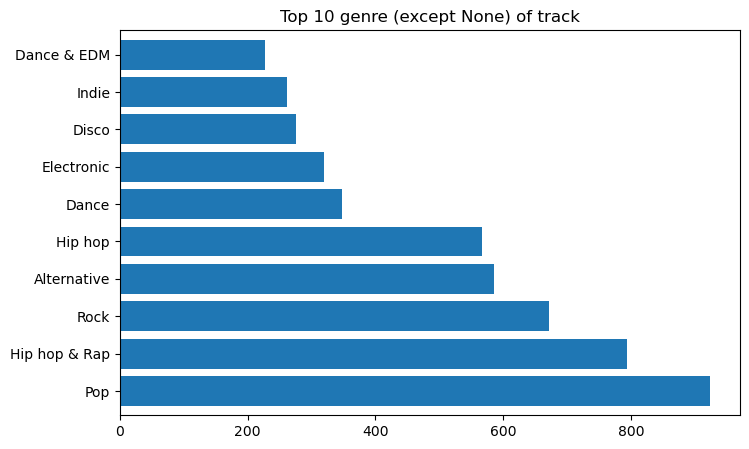

In [26]:
tracks_df[tracks_df['Tags']!='None']['Tags'].value_counts()[:10].plot.barh(width=0.8)
plt.title('Top 10 genre (except None) of track')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

---
### **3.1.2. Playlists**

### Load Data

In [27]:
playlists_df = pd.read_csv('playlist.csv')
playlists_df.head()

,ID,Name,Poster,NumTracks,TopTracks,Likes,Reposts,PostedTime,Genre,Length
0,P1,Gentle Dreams 🛏️ - An Indie/Chill/Electronic P...,U1,18,"['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8...",121377,9211,13 May 2017,indie,1:09:50
1,P2,Relaxing Sunday Mornings ☕ - An Indie/Folk/Pop...,U1,16,"['T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T1...",74566,4554,15 April 2017,indie,55:27
2,P3,Indie,U22,522,"['T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T2...",2236,149,22 June 2015,indie,2:13:41
3,P4,Indie,U32,379,"['T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T3...",1159,180,1 August 2014,indie,2:33:29
4,P5,indie ♥,U43,291,"['T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T4...",2300,685,21 January 2013,indie,2:25:35


### How many rows and columns does the data have?

Get the number of rows and columns of the DataFrame `playlists_df` and store it in `num_rows_playlist` and `num_cols_playlist` variables by counting length of DataFrame and counting columns of DataFrame

In [28]:
num_rows_playlist = len(playlists_df)
num_cols_playlist = len(playlists_df.columns)

print("Number of rows:", num_rows_playlist)
print("Number of columns:", num_cols_playlist)

Number of rows: 2000
Number of columns: 10


There are 2000 of rows, 10 of columns in `playlists_df`

### Does the data have duplicate?

Calculate the number of samples are duplicated based on `'ID'` field and store it in the variable `num_duplicated_rows`. In a group of samples, the first sample is not counted as duplicated by using (`keep='first'`). Then count number of duplications if their value are `True`

In [29]:
playlist_duplicate = playlists_df['ID'].duplicated(keep='first')
num_duplicated_rows = np.count_nonzero(playlist_duplicate == True)

print('Duplicate:', num_duplicated_rows)
playlists_df[playlist_duplicate == True]

Duplicate: 100


,ID,Name,Poster,NumTracks,TopTracks,Likes,Reposts,PostedTime,Genre,Length
340,P340,Lofi,U2298,309,"['T2959', 'T2960', 'T2961', 'T2962', 'T2963', ...",22,2,14 September 2018,lofi,2:23:53
380,P379,Vibes,U2228,207,"['T3260', 'T3261', 'T2846', 'T2847', 'T2849', ...",45,1,17 November 2022,lofi,1:46:08
405,P207,| Chill | Lofi | Hip Hop |,U1493,122,"['T1864', 'T1865', 'T1866', 'T1867', 'T1868', ...",98545,5614,28 October 2017,hiphop,1:56:39
406,P208,Study & Chill | Lofi Hiphop,U1502,24,"['T1873', 'T1874', 'T1875', 'T1876', 'T1877', ...",98276,5976,3 September 2018,hiphop,48:43
420,P210,lofi hip hop playlist,U1515,90,"['T1893', 'T1894', 'T1895', 'T1896', 'T1897', ...",61760,6913,22 February 2017,hiphop,2:28:01
...,...,...,...,...,...,...,...,...,...,...
1974,P1867,rock,U11449,447,"['T15919', 'T15920', 'T15921', 'T15922', 'T159...",7,7,27 February 2017,rock,2:33:55
1975,P1868,rock,U11455,481,"['T15928', 'T15929', 'T15930', 'T15931', 'T159...",3,6,20 April 2019,rock,2:12:48
1976,P1869,rock,U11457,63,"['T15938', 'T15764', 'T15085', 'T15939', 'T159...",2,9,13 April 2021,rock,1:44:43
1977,P1870,Rock,U11463,416,"['T15163', 'T190', 'T15943', 'T7338', 'T15236'...",9,72,25 April 2016,rock,2:35:24


Therefore having 100 duplicated data in `playlists_df`, we need to remove those duplicates. After removing, number of rows of `playlists_df` will be changed

In [30]:
duplicate_index = playlists_df[playlist_duplicate == True].index
playlists_df.drop(duplicate_index, inplace=True)
num_rows_playlist = len(playlists_df)
num_rows_playlist

1900

### Check Columns' Datatypes, adjust if needed

In [31]:
playlists_df['NumTracks'] = playlists_df['NumTracks'].apply(lambda col: col.replace(',', ''))
playlists_df[['NumTracks', 'Likes', 'Reposts']] = playlists_df[['NumTracks', 'Likes', 'Reposts']].replace(['None'], '0')
playlists_df[['NumTracks', 'Likes', 'Reposts']] = playlists_df[['NumTracks', 'Likes', 'Reposts']].astype(int)

playlists_df.dtypes

ID            object
Name          object
Poster        object
NumTracks      int64
TopTracks     object
Likes          int64
Reposts        int64
PostedTime    object
Genre         object
Length        object
dtype: object

In [32]:
playlists_df['PostedTime'] = pd.to_datetime(playlists_df['PostedTime'][playlists_df['PostedTime'] != 'None'], format='%d %B %Y')
playlists_df['Length'] = playlists_df['Length'].str.replace('^(\d+:\d+)$', r'0:\1', regex=True)
playlists_df['Length'] = playlists_df['Length'].apply(lambda col: np.nan if col=='None' else pd.Timedelta(col))

playlists_df.dtypes

ID                     object
Name                   object
Poster                 object
NumTracks               int64
TopTracks              object
Likes                   int64
Reposts                 int64
PostedTime     datetime64[ns]
Genre                  object
Length        timedelta64[ns]
dtype: object

### Find out distribution of numeric data columns

In [33]:
nume_cols = ['NumTracks', 'Likes', 'Reposts', 'PostedTime', 'Length']

missing_percentages = np.isnan(playlists_df[nume_cols]).sum() / num_rows_playlist * 100
mins = np.percentile(playlists_df[nume_cols], 0, axis=0)
medians = np.percentile(playlists_df[nume_cols], 50, axis=0)
maxs = np.percentile(playlists_df[nume_cols], 100, axis=0)

nume_cols_df_playlist = pd.DataFrame(data=np.array([missing_percentages, mins, medians, maxs]),
                                     index=['Missing percentage', 'Min', 'Median', 'Max'], columns=nume_cols)
nume_cols_df_playlist

,NumTracks,Likes,Reposts,PostedTime,Length
Missing percentage,0.0,0.0,0.0,0.315789,0.368421
Min,0.0,0.0,0.0,2012-11-06 00:00:00,0 days 00:02:44
Median,343.5,5.0,3.0,2017-11-28 12:00:00,0 days 02:52:56.500000
Max,4505.0,421046.0,177117.0,2022-11-26 00:00:00,12 days 22:25:17


### Find out distribution of non-numeric data columns

In [34]:
cate_cols = ['ID', 'Name', 'Poster', 'TopTracks', 'Genre']

missing_percentages = np.sum(playlists_df[cate_cols].isna()) / num_rows_playlist * 100
num_diff_vals = np.array(playlists_df[cate_cols].nunique())
diff_vals = np.array(playlists_df[cate_cols].apply(lambda col: col.dropna().unique()))

cate_cols_df_playlist = pd.DataFrame(data=np.array([missing_percentages, num_diff_vals, diff_vals]),
                                     index=['Missing percentage', 'Num diff val', 'Diff val'], columns=cate_cols)
cate_cols_df_playlist

,ID,Name,Poster,TopTracks,Genre
Missing percentage,0.0,0.0,0.0,0.0,0.0
Num diff val,1900,186,1793,1880,10
Diff val,"[P1, P2, P3, P4, P5, P6, P7, P8, P9, P10, P11,...",[Gentle Dreams 🛏️ - An Indie/Chill/Electronic ...,"[U1, U22, U32, U43, U54, U63, U70, U81, U89, U...","[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T...","[indie, lofi, hiphop, edm, disco, rap, acousti..."


### Drop missing value

In [35]:
PostedTime_missing = playlists_df[playlists_df['PostedTime'].isna()]
PostedTime_missing

,ID,Name,Poster,NumTracks,TopTracks,Likes,Reposts,PostedTime,Genre,Length
214,P215,None,U1551,0,[],0,0,NaT,lofi,NaT
396,P395,None,U1551,0,[],0,0,NaT,lofi,NaT
803,P771,None,U1551,0,[],0,0,NaT,disco,NaT
846,P814,None,U1551,0,[],0,0,NaT,disco,NaT
912,P880,None,U1551,0,[],0,0,NaT,disco,NaT
948,P916,None,U1551,0,[],0,0,NaT,disco,NaT


In [36]:
playlists_df.drop(PostedTime_missing.index, inplace=True)

In [37]:
Length_missing = playlists_df[playlists_df['Length'].isna()]
Length_missing

,ID,Name,Poster,NumTracks,TopTracks,Likes,Reposts,PostedTime,Genre,Length
1018,P982,rap,U6082,0,[],2,2,2020-04-23,rap,NaT


In [38]:
playlists_df.drop(Length_missing.index, inplace=True)

Check if NumTracks equals 0 and remove it

In [39]:
playlists_df[playlists_df['NumTracks']==0]

,ID,Name,Poster,NumTracks,TopTracks,Likes,Reposts,PostedTime,Genre,Length


Check if length of list of track of a playlist is empty

In [40]:
playlists_df['TopTracks'] = playlists_df['TopTracks'].apply(lambda x: re.findall("'([a-zA-Z0-9]+)'", x))
sum(playlists_df['TopTracks'].apply(lambda x: len(x)==0))

0

/home/minkoi/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NumTracks'>

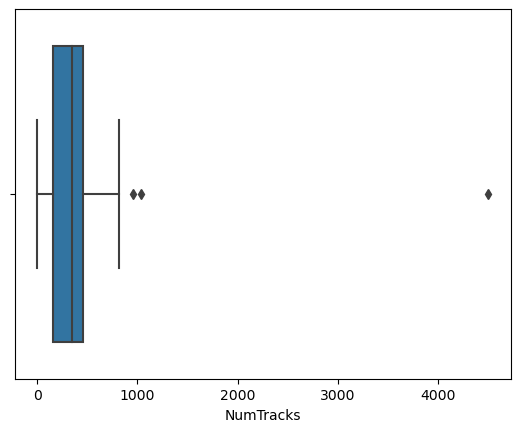

In [41]:
sns.boxplot(playlists_df['NumTracks'])

/home/minkoi/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Reposts'>

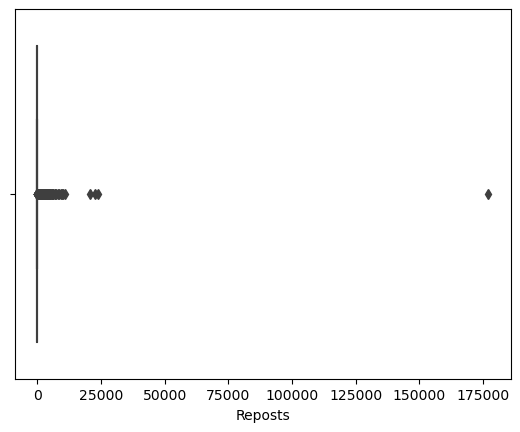

In [42]:
sns.boxplot(playlists_df['Reposts'])

---
### **3.1.3. Users**

### Load data

In [43]:
users_df = pd.read_csv('user.csv')
users_df.head()

,ID,Name,NumFollowers,NumFollowing,NumTracks,Verified,NextPro
0,U1,Kupla,21093,720,95,Verified,Next Pro
1,U2,Matt,357,0,46,None,None
2,U3,ZCR WORLD,241,97,12,None,None
3,U4,Amin Mohammadi,2443,55,23,None,None
4,U5,Dr'Q,4318,102,21,None,None


### How many rows and columns does the data have?

Get the number of rows and columns of the DataFrame `users_df` and store it in `num_rows_user` and `num_cols_user` variables by counting length of DataFrame and counting columns of DataFrame

In [44]:
num_rows_user = len(users_df)
num_cols_user = len(users_df.columns)

print("Number of rows:", num_rows_user)
print("Number of columns:", num_cols_user)

Number of rows: 11589
Number of columns: 7


There are 11589 of rows, 7 of columns in `users_df`

### Does the data have duplicate?

Calculate the number of samples are duplicated based on `'ID'` field and store it in the variable `num_duplicated_rows`. In a group of samples, the first sample is not counted as duplicated by using (`keep='first'`). Then count number of duplications if their value are `True`

In [45]:
user_duplicate = users_df['ID'].duplicated(keep='first')
num_duplicated_rows = np.count_nonzero(user_duplicate==True)

print('Duplicate:', num_duplicated_rows)

Duplicate: 0


There are 0 duplicates in `users_df`

### Check Columns' Datatypes, adjust if needed

In [46]:
users_df['NumFollowing'] = users_df['NumFollowing'].replace('1 person', '1')
users_df['NumFollowing'] = users_df['NumFollowing'].apply(lambda col: col.replace(',', ''))

users_df[['NumFollowers', 'NumFollowing', 'NumTracks']] = users_df[['NumFollowers', 'NumFollowing', 'NumTracks']].replace('None', '0')
users_df[['NumFollowers', 'NumFollowing', 'NumTracks']] = users_df[['NumFollowers', 'NumFollowing', 'NumTracks']].astype(int)

users_df.dtypes

ID              object
Name            object
NumFollowers     int64
NumFollowing     int64
NumTracks        int64
Verified        object
NextPro         object
dtype: object

In [47]:
users_df['Verified'] = users_df['Verified'].replace({'Verified':True, 'None':False})

users_df.dtypes

ID              object
Name            object
NumFollowers     int64
NumFollowing     int64
NumTracks        int64
Verified          bool
NextPro         object
dtype: object

### Find out distribution of numeric data columns

In [48]:
nume_cols = ['NumFollowers', 'NumFollowing', 'NumTracks']

missing_percentages = np.isnan(users_df[nume_cols]).sum() / num_rows_user * 100
mins = np.percentile(users_df[nume_cols], 0, axis=0)
medians = np.percentile(users_df[nume_cols], 50, axis=0)
maxs = np.percentile(users_df[nume_cols], 100, axis=0)

nume_cols_df_user = pd.DataFrame(data=np.array([missing_percentages, mins, medians, maxs]),
                                 index=['Missing percentage', 'Min', 'Median', 'Max'], columns=nume_cols)
nume_cols_df_user

,NumFollowers,NumFollowing,NumTracks
Missing percentage,0.0,0.0,0.0
Min,0.0,0.0,0.0
Median,992.0,18.0,19.0
Max,10111989.0,2024.0,24393.0


### Find out distribution of non-numeric data columns

In [49]:
cate_cols = ['ID', 'Name', 'Verified', 'NextPro']

missing_percentages = np.sum(users_df[cate_cols].isna()) / num_rows_user * 100
num_diff_vals = np.array(users_df[cate_cols].nunique())
diff_vals = np.array(users_df[cate_cols].apply(lambda col: col.dropna().unique()))

cate_cols_df_user = pd.DataFrame(data=np.array([missing_percentages, num_diff_vals, diff_vals]),
                                 index=['Missing percentage', 'Num diff val', 'Diff val'], columns=cate_cols)
cate_cols_df_user

,ID,Name,Verified,NextPro
Missing percentage,0.0,0.0,0.0,0.0
Num diff val,11589,11574,2,3
Diff val,"[U1, U2, U3, U4, U5, U6, U7, U8, U9, U10, U11,...","[Kupla , Matt, ZCR WORLD, Amin Mohammadi, D...","[True, False]","[Next Pro, None, Pro]"


### Remove rows containing missing values if available

Missing percentage of all field is 0 so we can skip this step

/home/minkoi/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NumFollowing'>

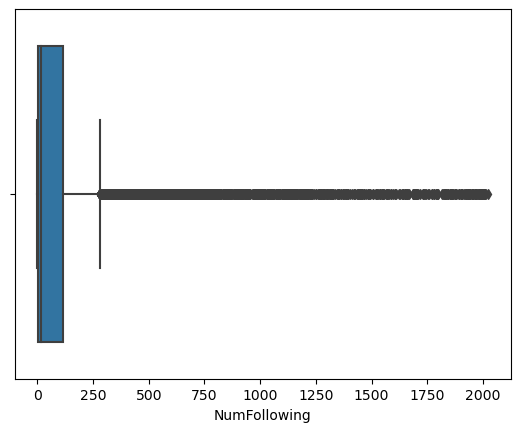

In [50]:
sns.boxplot(users_df['NumFollowing'])

/home/minkoi/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NumFollowers'>

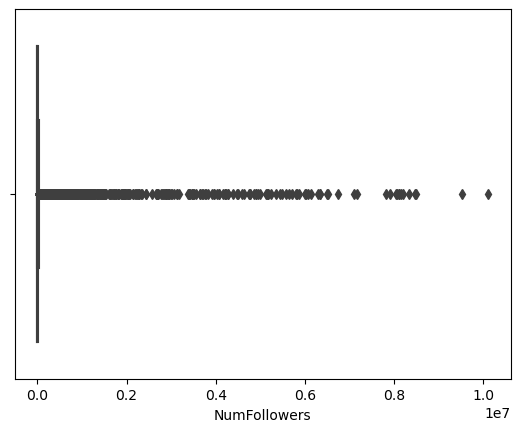

In [51]:
sns.boxplot(users_df['NumFollowers'])

/home/minkoi/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NumTracks'>

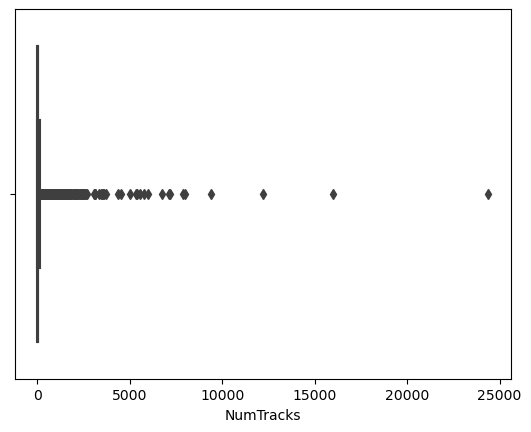

In [52]:
sns.boxplot(users_df['NumTracks'])

***Comment:*** We can see that there are outliers, but since it can tell us something about the other field in the rows, we won't delete it until the query is about "NumFollowers," "NumFollowing," or something similar.

---
## **3.2. Making Question**

### **Question 1**

***What is the ratio between the "verified users" and "None verified users" ?***

1. Calculate the ratio of verified users and None verified users to show that the most/ the least kind of user in soundcloud in recent years

2. Draw a pie chart to show the ratio

### Preprocessing

No need to preprocess

### Data Analysis

In [53]:
verified_user_df = users_df.loc[users_df['Verified'] == True]

verified_user_ratio = len(verified_user_df) / len(users_df) 
none_verified_user_ratio = 1 - verified_user_ratio

### Data Visualization

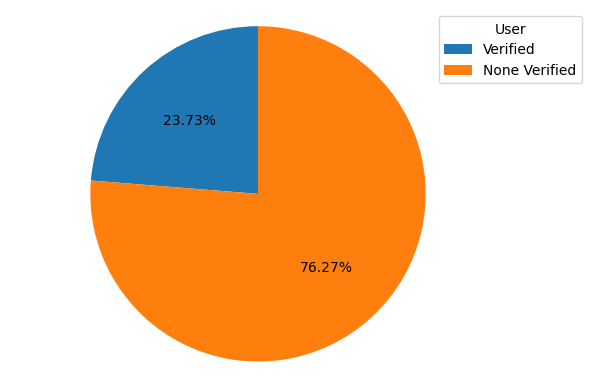

In [54]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
mylabels = ['Verified', 'None Verified']
sizes = [verified_user_ratio * 100, none_verified_user_ratio * 100]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, autopct='%.2f%%', startangle=90)
ax1.axis('equal')
plt.legend(title = "User", bbox_to_anchor=(0.85, 1), loc='upper left', labels=mylabels)

plt.show()

### Answer

None verified users make up the majority (approximately 83.95%) of users. Verified users are less than (approximately 16.05%).
- It shows that the imbalance between two kinds of user. 
- A large of people just like to hear music and post music on soundcloud for personal entertainment purposes or contribute their products to the community. In my opinion, maybe they do not want to be famous or well-known creators

---
### **Question 2**

***Does those users who are verified have more followers than those ones who are not?***

### Preprocessing

In [55]:
verified = users_df[users_df['Verified'] == True]
non_verified = users_df[users_df['Verified'] == False]

In [56]:
verified

,ID,Name,NumFollowers,NumFollowing,NumTracks,Verified,NextPro
0,U1,Kupla,21093,720,95,True,Next Pro
12,U13,Dead Oceans,123394,20,233,True,Next Pro
20,U21,Fatboy Slim,307312,3,571,True,None
21,U22,Patrick Baker,9890,663,56,True,Pro
23,U24,Murda Beatz,147799,0,116,True,None
...,...,...,...,...,...,...,...
11533,U11534,SOURCE,46023,7,213,True,None
11547,U11548,"quickly, quickly",56407,283,63,True,Pro
11577,U11578,Thomas Azier,10982,38,91,True,None
11578,U11579,Portugal. The Man,2276562,26,273,True,Next Pro


In [57]:
non_verified

,ID,Name,NumFollowers,NumFollowing,NumTracks,Verified,NextPro
1,U2,Matt,357,0,46,False,None
2,U3,ZCR WORLD,241,97,12,False,None
3,U4,Amin Mohammadi,2443,55,23,False,None
4,U5,Dr'Q,4318,102,21,False,None
5,U6,DatBoiCoop_,111,27,17,False,None
...,...,...,...,...,...,...,...
11583,U11584,KA$HPHON,1679,4,65,False,None
11585,U11586,SBG Movement 2011,900,0,20,False,None
11586,U11587,Play It Down,20141,158,234,False,Next Pro
11587,U11588,Noname,154940,30,24,False,None


### Data Analysis

In [58]:
q1_ver = verified['NumFollowers'].quantile(0.25)
q2_ver = verified['NumFollowers'].quantile(0.5)
q3_ver = verified['NumFollowers'].quantile(0.75)
print(q1_ver)
print(q2_ver)
print(q3_ver)

19357.75
52766.0
174812.5


In [59]:
print(len(verified[verified['NumFollowers'] < q1_ver]))
print(len(verified[(verified['NumFollowers'] >= q1_ver) & (verified['NumFollowers'] < q2_ver)]))
print(len(verified[(verified['NumFollowers'] >= q2_ver) & (verified['NumFollowers'] < q3_ver)]))
print(len(verified[verified['NumFollowers'] >= q3_ver]))

688
687
687
688


In [60]:
q1_nonver = non_verified['NumFollowers'].quantile(0.25)
q2_nonver = non_verified['NumFollowers'].quantile(0.5)
q3_nonver = non_verified['NumFollowers'].quantile(0.75)
print(q1_nonver)
print(q2_nonver)
print(q3_nonver)

49.0
356.0
2101.5


In [61]:
print(len(non_verified[non_verified['NumFollowers'] < q1_nonver]))
print(len(non_verified[(non_verified['NumFollowers'] >= q1_nonver) & (non_verified['NumFollowers'] < q2_nonver)]))
print(len(non_verified[(non_verified['NumFollowers'] >= q2_nonver) & (non_verified['NumFollowers'] < q3_nonver)]))
print(len(non_verified[non_verified['NumFollowers'] >= q3_nonver]))

2193
2223
2213
2210


In [62]:
print(verified['NumFollowers'].max())
print(non_verified['NumFollowers'].max())

10111989
2883793


In [63]:
cols = ['[0,20k)', '[20k, 40k)', '[40k, 60k)', '[60k, 80k)', '[80k, 100k)', '[100k, 120k)',\
        '[120k, 140k)', '[140k, 160k)', '[160k, 180k)', '[180k, 200k)', '[200k, 11m)']
bins = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 11000000]
count_ver = []
count_nonver = []

for i in range(len(bins) - 1):
    count_ver.append(verified[(verified['NumFollowers'] >= bins[i]) & (verified['NumFollowers'] < bins[i+1])].shape[0])
    count_nonver.append(non_verified[(non_verified['NumFollowers'] >= bins[i]) & \
                                     (non_verified['NumFollowers'] < bins[i+1])].shape[0])

print(count_ver)
print(count_nonver)

[715, 473, 276, 184, 143, 82, 78, 71, 54, 51, 623]
[8553, 158, 47, 28, 16, 8, 5, 4, 3, 3, 14]


In [64]:
avg_verified_followers = verified['NumFollowers'].sum() / len(verified['NumFollowers'])
avg_nonverified_followers = non_verified['NumFollowers'].sum() / len(non_verified['NumFollowers'])
print(avg_verified_followers.round(0))
print(avg_nonverified_followers.round(0))

345873.0
4211.0


### Data Visualization

*Compare number of followers of two user groups*

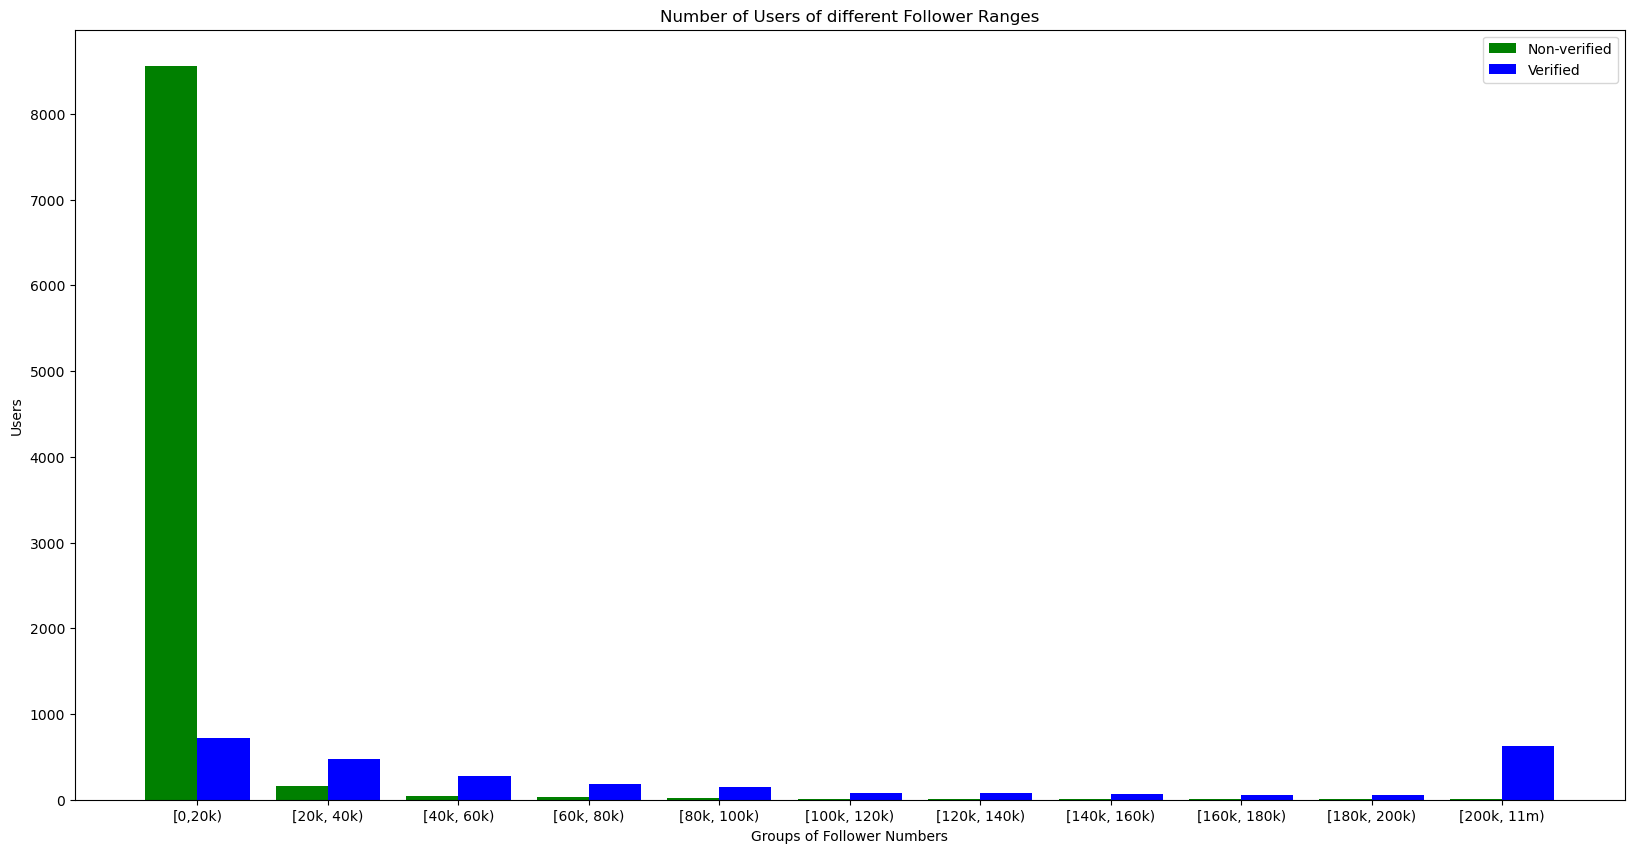

In [65]:
fig = plt.figure(figsize=(20, 10))

x_axis = np.arange(len(cols))

plt.bar(x_axis - 0.2, count_nonver, 0.4, label = 'Non-verified', color = 'green')
plt.bar(x_axis + 0.2, count_ver, 0.4, label = 'Verified', color = 'blue')

plt.xticks(x_axis, cols)
plt.xlabel('Groups of Follower Numbers')
plt.ylabel('Users')
plt.title('Number of Users of different Follower Ranges')
plt.legend()
plt.show()

### Answer

As what can be seen from the chart, considering 2750 Verified Users and 8839 Non-verified Users, the number of Non-verified Users belonging to group from 0 to 20000 followers stands at around 8500, when the figures for the remaining groups are only below 200 users. Meanwhile, the number of Verified Users decreases from around 700 (Group from 0 to 20000 followers) to just above 50 users for group from 180000 to 200000 followers. However, there are upto more than 600 users belonging to group from 200000 to 11 million users. Moreover, the average number of followers of Verified Users is significantly greater than the figure for Non-verified Users, 345873 followers compared to 4211 followers. To summerize, it can be concluded that those users who are verified will have more followers than those ones who are not.

---
### **Question 3**

***Find out popular songs posted in the last 5 years***

- Data: track.csv
- Idea: To display top 10 popular songs of each year in the last 5 years first we need to get the corresponding data set which means get columns Name, Plays, Likes, Reposts, PostedTime and Year. Year is not in the original data set but is added by interpolating from the PostedTime. Next we will classify tracks to corresponding year (2018 to 2022) base on its name and number of plays. After that, sorting tracks by its number of plays descending so we can get top 10 tracks with the most played time. Finally, display top 10 popular songs of each year in the last 5 years.

### Preprocessing

In [66]:
popular_tracks = tracks_df[['Name', 'Plays', 'Likes', 'Reposts', 'PostedTime']].dropna()
popular_tracks['Year'] = popular_tracks['PostedTime'].dt.year
index_order = range(0, len(popular_tracks))
popular_tracks = pd.DataFrame(popular_tracks, index = index_order)

### Data Analysis

In [67]:
# list store top 10 tracks of each year based on number of plays
latest_5_years = [{}, {}, {}, {}, {}]
for i in range(len(popular_tracks)):
    if popular_tracks['Year'][i] == 2018:
        latest_5_years[0][popular_tracks['Name'][i]] = popular_tracks['Plays'][i]
    elif popular_tracks['Year'][i] == 2019:
        latest_5_years[1][popular_tracks['Name'][i]] = popular_tracks['Plays'][i]
    elif popular_tracks['Year'][i] == 2020:
        latest_5_years[2][popular_tracks['Name'][i]] = popular_tracks['Plays'][i]
    elif popular_tracks['Year'][i] == 2021:
        latest_5_years[3][popular_tracks['Name'][i]] = popular_tracks['Plays'][i]
    elif popular_tracks['Year'][i] == 2022:
        latest_5_years[4][popular_tracks['Name'][i]] = popular_tracks['Plays'][i]
# sorting dictionary to get most played tracks
# get top 10 tracks
for i in range(len(latest_5_years)):
    latest_5_years[i] = dict(sorted(latest_5_years[i].items(), key=lambda item: item[1], reverse = True))
    latest_5_years[i] = list(latest_5_years[i].keys())[0: 10]

### Data Visualization

In [68]:
# store to DataFrame
columns_name = ['2018', '2019', '2020', '2021', '2022']
index_names = ['Top 1', 'Top 2','Top 3','Top 4','Top 5','Top 6','Top 7','Top 8','Top 9', 'Top10']
data = dict(zip(columns_name, latest_5_years))
most_played_tracks_5years = pd.DataFrame(data, index = index_names)
most_played_tracks_5years

,2018,2019,2020,2021,2022
Top 1,약속 By JIMIN Of BTS,Robbery,Future - March Madness,Calling My Phone (feat. 6lack),NLE Choppa - Capo
Top 2,Lucid Dreams,Lil Tecca - Ransom,NLE Choppa - Camelot,Monëy so big,Future feat. Drake & Tems - WAIT FOR U
Top 3,"Lil Baby, Gunna - Drip Too Hard",Polo G feat. Lil TJay - Pop Out,Wishing Well,كليب انا بعشقني اوي يابا عصام صاصا الكروان - ...,Future - PUFFIN ON ZOOTIEZ
Top 4,Post Malone - rockstar (feat. 21 Savage),Ballin' (with Roddy Ricch),"Lemonade Ft. Don Toliver, Gunna & NAV",By Your Side,Hide & Seek
Top 5,Envy Me,DaBaby - Suge,Future - Purple Reign,Astronaut In The Ocean,POLAND - LIL YACHTY(PROD. F1LTHY)
Top 6,F.N,MIDDLE CHILD,Future - Perkys Calling,مهرجان وسط دموع وجراح ( ع الواتس الف رساله مبع...,Waddup (feat. Polo G)
Top 7,I Kill People! ft Tadoe & Chief Keef [Produced...,Pop Smoke - Dior,Pop Smoke - Element,Already Dead,YoungBoy Never Broke Again - Bring The Hook
Top 8,ZEZE (feat. Travis Scott & Offset),23 Island,Drake - Laugh Now Cry Later (feat. Lil Durk),Drake - Girls Want Girls (feat. Lil Baby),Polo G - Distraction
Top 9,Lean Wit Me,Empty,Future - All Right,Burn,BILLIE EILISH.
Top10,YoungBoy Never Broke Again - Outside Today,"Taki Taki (feat. Selena Gomez, Ozuna & Cardi B)",Come & Go Ft. Marshmello,مهرجان ايوا احتليت كوكب كونتر ( ملك الموت جي ب...,FOR FUN Prod. By BEATSBYJEFF


### Answer

We know which song is popular base on its number of plays then we can make a popular songs chart and recommend it to users.

---
### **Question 4**

***What is the best linear regression model that show correlation between number of plays of a track and its number of likes, reposts and comments?***

### Preprocessing

In [69]:
tracks_df

,ID,Name,Poster,Plays,Likes,Reposts,PostedTime,Tags,Length,NumComments
0,T1,Locked Up,U4190,1033050,15590,421,2005-01-01,R&B,NaT,84
3,T4,Dabin x Fytch - Altitude,U4868,324493,7536,1018,2018-09-28,Electronic,0 days 00:03:27,85
4,T5,earned it,U3052,42037,805,71,2018-07-28,Lofi,0 days 00:03:33,11
5,T6,LOST IN MUSIC (DSD Balearic Mix),U2800,39261,1440,381,2018-10-30,Disco,0 days 00:07:40,34
7,T8,Whole Lotta Money - Remix (The Frenchies Remix),U6648,549036,8054,202,2021-11-03,House,0 days 00:06:41,135
...,...,...,...,...,...,...,...,...,...,...
16163,T16164,Monkey Bars - Colors,U3054,107295,1489,91,2014-11-12,None,0 days 00:04:25,4
16164,T16165,Cold days w/ j'san.,U10551,1067592,8761,497,2017-09-01,None,0 days 00:02:04,83
16169,T16170,the burn marks on my epiano wont go away,U253,4206783,48393,4353,2016-01-27,None,0 days 00:01:36,1211
16183,T16184,Rossa-Terlalu Cinta,U1387,1404120,20584,282,2013-12-31,None,0 days 00:04:00,175


In [70]:
lr_df = pd.concat((tracks_df[['Plays', 'Likes', 'Reposts']], tracks_df['NumComments']), axis = 1)
lr_df.head()

,Plays,Likes,Reposts,NumComments
0,1033050,15590,421,84
3,324493,7536,1018,85
4,42037,805,71,11
5,39261,1440,381,34
7,549036,8054,202,135


In [71]:
x = lr_df.drop(['Plays'], axis = 1).values
y = lr_df['Plays'].values

### Data Analysis

In [72]:
# Split initial datasets into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [73]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [74]:
# Coefficient of each Feature
coef = lr.coef_
coef = list(coef)
coef = [coef[i].round(3) for i in range(len(coef))]
coef

[68.301, 0.02, 553.235]

In [75]:
# Predict values
y_pred = lr.predict(x_test)
print(y_pred)

[-164425.06099534 1376667.96927179 3139232.140015   ... -219974.91518582
  361102.25129037 8073119.27613368]


In [76]:
# Evaluate the model
r2_score(y_test, y_pred)

0.9561415339699525

### Data Visualization

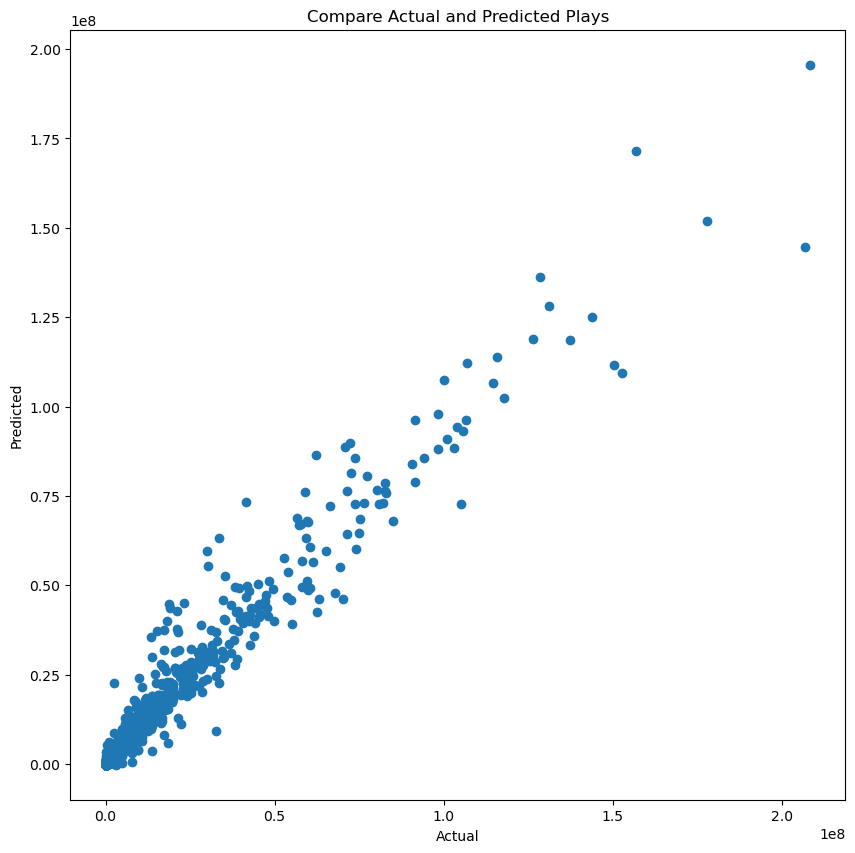

In [77]:
plt.figure(figsize = (10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Compare Actual and Predicted Plays')
plt.show()

### Answer

***Linear Regression Model***

$$\text{Plays} = 73.152(Likes) + 0.015(Reposts) + 262.24(NumComments)$$

---
### **Question 5**

***Number of tracks posted over the last 5 years***

### Preprocessing

No need to preprocess

### Data Analysis

In [78]:
temp = pd.DataFrame(data=np.array([tracks_df['ID'], tracks_df['PostedTime'].dt.year, tracks_df['PostedTime'].dt.month]).T,
                    columns=['ID', 'Year', 'Month'])
temp = temp[temp['Year'] >= 2018].set_index('ID')
temp = pd.DataFrame(temp.groupby(['Year', 'Month']).size())
num_tracks_each_month = temp.groupby('Year')[0].apply(pd.Series.tolist).tolist()
num_tracks_each_month[len(num_tracks_each_month) - 1].append(0)
months = np.arange(1, 13)

num_tracks_each_month

[[89, 91, 104, 115, 105, 99, 100, 95, 80, 87, 90, 60],
 [71, 60, 85, 58, 62, 79, 78, 71, 59, 61, 52, 50],
 [49, 49, 50, 51, 38, 17, 49, 41, 31, 34, 21, 36],
 [48, 36, 24, 24, 26, 15, 7, 21, 15, 31, 15, 11],
 [14, 21, 10, 27, 24, 32, 31, 18, 38, 41, 108, 0]]

### Data Visualization

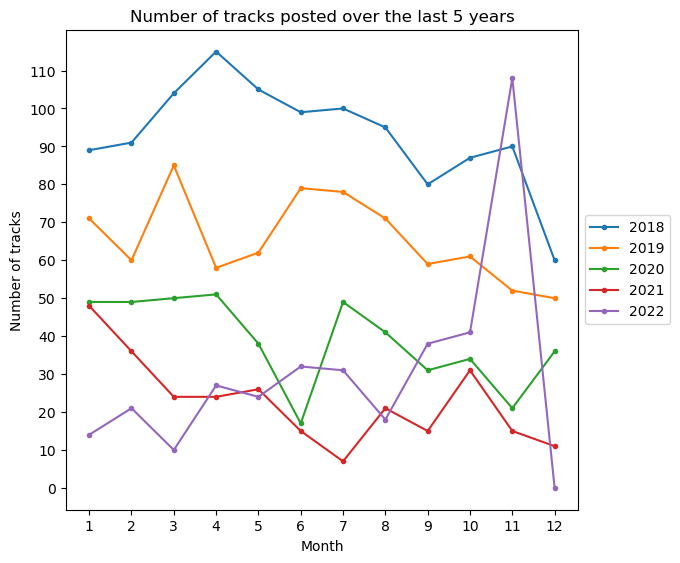

In [79]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_xticks(np.arange(1, 13, 1))
axes.set_yticks(np.arange(0, np.max(num_tracks_each_month), 10))
for i in range(0, 5):
    axes.plot(months, num_tracks_each_month[i], '.-', label=2018 + i)
box = axes.get_position()
axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes.set_xlabel('Month')
axes.set_ylabel('Number of tracks')
axes.set_title('Number of tracks posted over the last 5 years');

### Answer

Note: Because the collecting data time is in 11/2022, there is no data of 12/2022.

Answer: by observing the line chart above, we can draw some conclusions from that
1. The number of posted tracks decreases in recent years.
2. People usually post tracks on the first half of the year (in 2018 the month that has most tracks posted is April, in 2019 is March, in 2020 is April, in 2021 is January). Only in 2022, November has an outstanding number of data. It's maybe because the method that we use for collecting data.

---
### **Question 6**

***Does a playlist have a longer duration, the higher the number of likes?***

- Purpose: Observe the playlist.csv, some playlists with a long duration time have large number of likes. We want to clarify the correlation between the length of a playlist and the number of likes of that playlist in the whole data set.
- Data: playlist.csv

### Preprocessing

No need to preprocess

### Data Analysis

### Data Visualization

Text(0.5, 1.0, 'Mối tương quan giữa số lượt thích (Likes) và thời lượng (Length)')

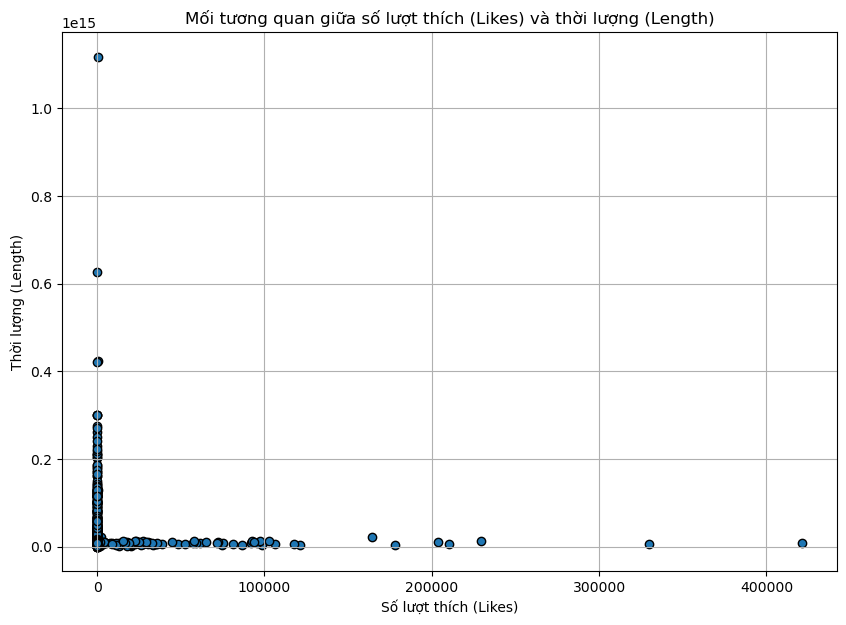

In [80]:
plt.figure(figsize=(10,7))
plt.grid()
plt.scatter(playlists_df['Likes'], playlists_df['Length'], edgecolors='black')
plt.xlabel('Số lượt thích (Likes)') 
plt.ylabel('Thời lượng (Length)')
plt.title('Mối tương quan giữa số lượt thích (Likes) và thời lượng (Length)')

### Answer

From the scatter plot above it is easy to see that there is no correlation, or very little correlation between length of a playlist and the number of likes of that playlist.

---
### **Question 7**

***So far, which genre has the highest average repost?***

1. Calculate average repost of each genre to show that the most/ the least kind of genre

2. Draw a bar chart horizontally to show result

### Preprocessing

No need to preprocess

### Data Analysis

In [81]:
most_repost_genre = playlists_df.groupby(['Genre'])['Reposts'].mean().sort_values(ascending = True)

### Data Visualization

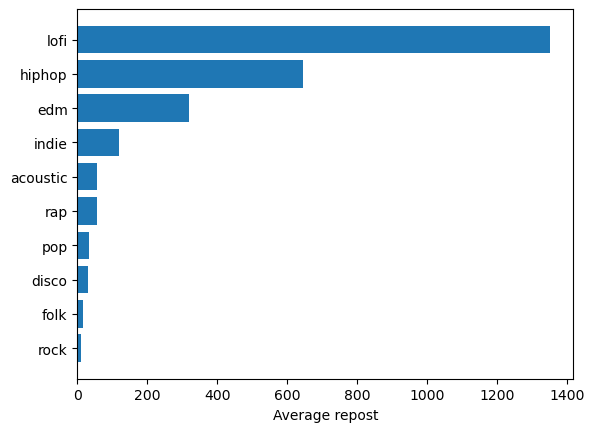

In [82]:
plt.barh(y = most_repost_genre.index, width=most_repost_genre.values)
plt.xlabel("Average repost")
plt.show()

### Answer

- The bar chart says that: 
    + The most average repost is genre Lofi
    + The least average repost is genre Rock

- In this bar char, we can 'implicitly predict' that the trending of genre is Lofi, people nowadays keen on hearing and reposting these kinds of music.

---
### **Question 8**

***Comparing the number of plays, likes between Next Pro, Pro, and ordinary users.***

### Preprocessing

No need to preprocess

### Data Analysis

In [83]:
user_track = pd.merge(tracks_df[['ID', 'Poster', 'Plays', 'Likes']], users_df[['ID', 'NextPro']], left_on='Poster', right_on='ID')
data = np.array(user_track.groupby('NextPro').mean()).T
plays = data[0]
likes = data[1]
keys = ['NextPro', 'None', 'Pro']
palette_color = sns.color_palette('dark')

plays, likes

(array([4873439.53564899, 3262178.62277253, 1927133.4611399 ]),
 array([67473.89892922, 45762.85091609, 25650.4119171 ]))

### Data Visualization

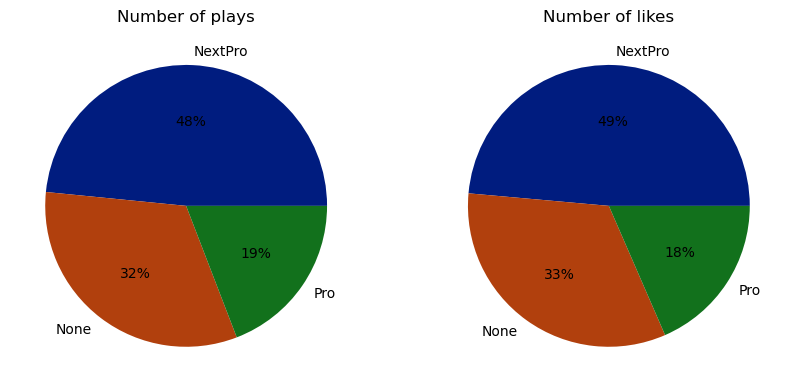

In [84]:
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(10, 10))
axes1.pie(plays, labels=keys, colors=palette_color, autopct='%0.f%%')
axes1.set_title('Number of plays')
axes2.pie(likes, labels=keys, colors=palette_color, autopct='%0.f%%')
axes2.set_title('Number of likes');

### Answer

As we can see from the 2 pie charts, tracks uploaded by NextPro users are the most popular and favorite. Followed by tracks from None users (ordinary users) and tracks posted by Pro users get the least attention. It seems that the NextPro service are favored among popular users, in the other hand the Pro service is not atractted enough and maybe there are not many popular users that pay for it.

---
### **Question 9**

***Users with a large following; the playlist has a sizable audience?***

### Preprocessing

In [85]:
users_df['NextPro'] = users_df['NextPro'].replace({'Next Pro':True, 'Pro':True, 'None':False})

### Data Analysis

In [86]:
def removeOutliers(df,colname):    
    q3, q1 = np.percentile(df[colname], [75, 25])
    IQR = q3 - q1
#     print('Last length:',len(df))
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    df = df[df[colname] < upper_bound]
    df = df[df[colname] > lower_bound]
#     print('After length:',len(df))
    return df


In [87]:
users_id = playlists_df.Poster.to_list()
playlist_user = playlists_df[['ID','Likes','Poster','Reposts','Length']]
playlist_user

,ID,Likes,Poster,Reposts,Length
0,P1,121377,U1,9211,0 days 01:09:50
1,P2,74566,U1,4554,0 days 00:55:27
2,P3,2236,U22,149,0 days 02:13:41
3,P4,1159,U32,180,0 days 02:33:29
4,P5,2300,U43,685,0 days 02:25:35
...,...,...,...,...,...
1995,P1896,1,U11565,1,0 days 02:15:15
1996,P1897,9,U11574,1,0 days 01:27:12
1997,P1898,1,U11578,12,0 days 00:36:13
1998,P1899,1,U11581,39,0 days 02:35:53


In [88]:
playlist_user = pd.merge(playlist_user, users_df, how='inner', left_on = 'Poster', right_on = 'ID',suffixes=('_playlist', '_user'))
playlist_user

,ID_playlist,Likes,Poster,Reposts,Length,ID_user,Name,NumFollowers,NumFollowing,NumTracks,Verified,NextPro
0,P1,121377,U1,9211,0 days 01:09:50,U1,Kupla,21093,720,95,True,True
1,P2,74566,U1,4554,0 days 00:55:27,U1,Kupla,21093,720,95,True,True
2,P3,2236,U22,149,0 days 02:13:41,U22,Patrick Baker,9890,663,56,True,True
3,P4,1159,U32,180,0 days 02:33:29,U32,acy,14,0,5,False,False
4,P92,20,U32,5,0 days 02:25:40,U32,acy,14,0,5,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1888,P1896,1,U11565,1,0 days 02:15:15,U11565,Stash Konig,2091,323,19,False,False
1889,P1897,9,U11574,1,0 days 01:27:12,U11574,StrangeFowx,37,348,0,False,False
1890,P1898,1,U11578,12,0 days 00:36:13,U11578,Thomas Azier,10982,38,91,True,False
1891,P1899,1,U11581,39,0 days 02:35:53,U11581,Jorge De La Rosa,97,14,32,False,False


In [89]:
average = playlist_user[['NumFollowers','Likes','ID_user','Reposts','Length','NumFollowing','NumTracks','Verified','NextPro']].groupby('ID_user').agg('mean')

### Data Visualization

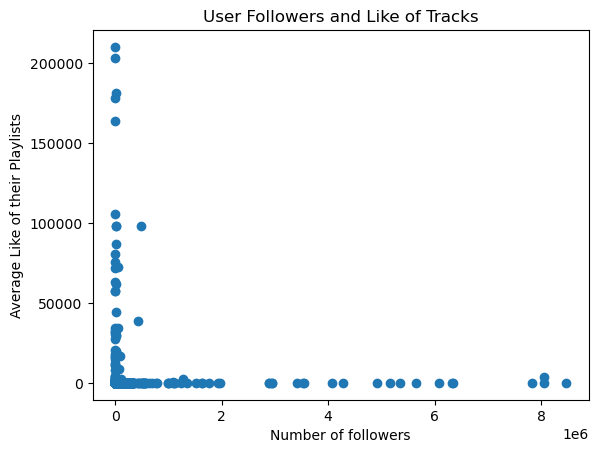

In [90]:
plt.scatter(average['NumFollowers'],average['Likes'] )
plt.title('User Followers and Like of Tracks')
plt.xlabel('Number of followers')
plt.ylabel('Average Like of their Playlists')
plt.show()

We can observe that even people with a small number of followers may have popular playlists. Having a large following does not ensure that their albums will receive more likes.

<AxesSubplot:>

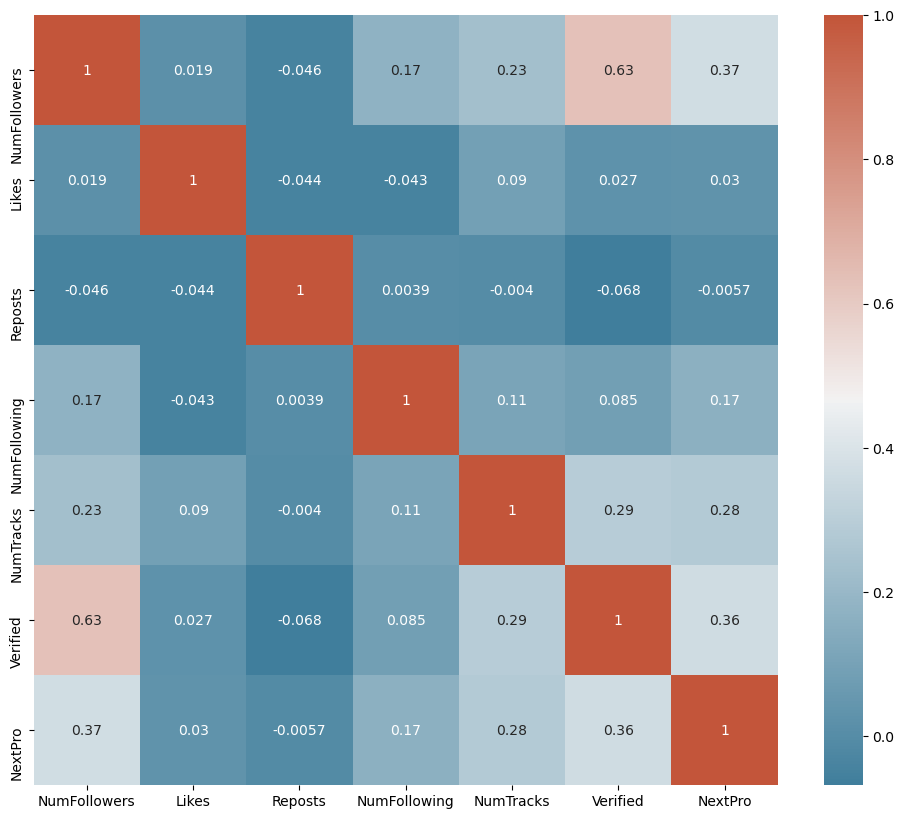

In [91]:
average = removeOutliers(average,'Likes')
average = removeOutliers(average,'NumFollowers')
average = removeOutliers(average,'Reposts')
corr = average[['NumFollowers','Likes','Reposts','NumFollowing','NumTracks','Verified','NextPro']].corr()

f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)

### Answer

After outliers are removed, we can observe that a person's following, verified user, or Next Pro status has no influence much on how many times their playlist is liked or reposted.

---
### **Question 10**

***Compare the correlation of the likes of the playlist and the average likes of the first 10 tracks in the playlist***

### Preprocessing

No need to preprocess

### Data Analysis

In [92]:
tracks_df.index = tracks_df['ID']
mean_like = playlists_df['TopTracks'].apply(lambda x: pd.Series(x).apply(lambda y:tracks_df.loc[y]['Likes']).mean())

In [93]:
mean_like

0        5409.8
1       51696.1
2       40462.1
3       75620.0
4        3188.8
         ...   
1995    59644.8
1996    16422.6
1997    56035.0
1998    31576.5
1999     5500.9
Name: TopTracks, Length: 1893, dtype: float64

### Data Visualization

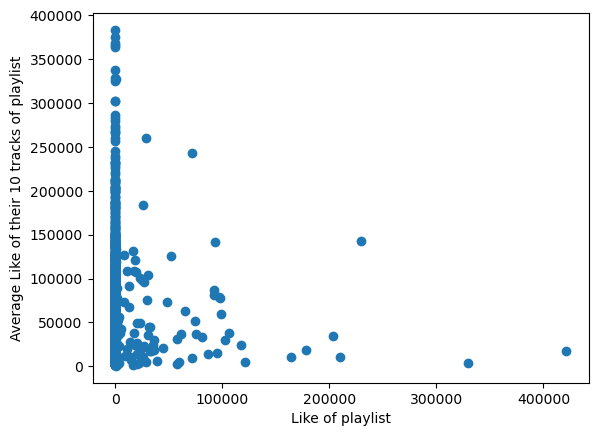

In [94]:
plt.scatter(playlists_df['Likes'],mean_like )
plt.xlabel('Like of playlist')
plt.ylabel('Average Like of their 10 tracks of playlist')
plt.show()

### Answer

Because a track may be on numerous playlists and users can access songs through different playlists as well as by themselves, the average like of their playlist's first 10 tracks might be significantly greater than the quantity of playlist likes.

---
### **Question 11**

***Based on user information and track forecast number of likes.***

### Preprocessing

In [95]:
track_user = pd.merge(users_df, tracks_df, how='inner', left_on = 'ID', right_on = 'Poster',suffixes=('_user', '_track'))
track_user = track_user[['NumFollowers','NumFollowing','NumTracks','Verified','NextPro','Name_track','Tags','Length','Likes','Plays','Reposts']]
track_user.head()

,NumFollowers,NumFollowing,NumTracks,Verified,NextPro,Name_track,Tags,Length,Likes,Plays,Reposts
0,21093,720,95,True,True,I will wait for you to come home,Chill,0 days 00:02:10,2411,213251,229
1,21093,720,95,True,True,Alone in the World,Chill,0 days 00:02:17,1833,139150,157
2,21093,720,95,True,True,Aurora,Chill,0 days 00:02:27,1127,65534,162
3,21093,720,95,True,True,Kupla X j'san - Out Of Town,Chill,0 days 00:02:32,1144,81721,115
4,21093,720,95,True,True,Kupla x less.people - lost in translation,Chill,0 days 00:02:12,985,77259,85


Add new feature length of the name and convert length of tracks to seconds

In [96]:
track_user['Length'] = track_user['Length'].apply(lambda x: x.total_seconds())
track_user['NameLength'] = track_user['Name_track'].apply(lambda x: len(x))

In [97]:
del track_user['Name_track'] 
track_user

,NumFollowers,NumFollowing,NumTracks,Verified,NextPro,Tags,Length,Likes,Plays,Reposts,NameLength
0,21093,720,95,True,True,Chill,130.0,2411,213251,229,32
1,21093,720,95,True,True,Chill,137.0,1833,139150,157,18
2,21093,720,95,True,True,Chill,147.0,1127,65534,162,6
3,21093,720,95,True,True,Chill,152.0,1144,81721,115,27
4,21093,720,95,True,True,Chill,132.0,985,77259,85,41
...,...,...,...,...,...,...,...,...,...,...,...
16163,20141,158,234,False,True,Tech House,326.0,1019,24817,141,50
16164,35924,217,186,False,True,Disco,184.0,140,5658,18,97
16165,35924,217,186,False,True,None,250.0,1153,20831,651,58
16166,35924,217,186,False,True,None,235.0,440,14054,46,55


Remove the outliers and fill nan value of length of track

In [98]:
track_user = removeOutliers(track_user,'Likes')
print(track_user.isnull().sum())
track_user['Length']= track_user['Length'].fillna(track_user['Length'].median())
track_user.isnull().sum()

NumFollowers       0
NumFollowing       0
NumTracks          0
Verified           0
NextPro            0
Tags               0
Length          1259
Likes              0
Plays              0
Reposts            0
NameLength         0
dtype: int64


NumFollowers    0
NumFollowing    0
NumTracks       0
Verified        0
NextPro         0
Tags            0
Length          0
Likes           0
Plays           0
Reposts         0
NameLength      0
dtype: int64

### Data Analysis

Split the dataset into train set and test set

In [99]:
x = track_user[track_user['Tags'].isin(popular_genre)]
y = x.Likes
x = x.drop(['Likes'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

Label Tags field 

In [100]:
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

ordinal_encoder = OrdinalEncoder()
label_X_train[['Tags']] = ordinal_encoder.fit_transform(X_train[['Tags']])
label_X_valid[['Tags']] = ordinal_encoder.transform(X_valid[['Tags']])


Train the model

In [101]:
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=40,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(label_X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=1)

Test and calculate error by using mean_absolute_error

In [102]:
likepredict = rf.predict(label_X_valid)

In [103]:
print(mean_absolute_error(y_valid, likepredict))
likepredict[:10]

3750.6361646234677


array([35356, 25825,   389,  2299, 43997,    45, 37589,    27,  1204,
          33])

In [104]:
y_valid[:10]

16162    36297
3755     14471
12934      695
12540     4150
5261     31394
10710      101
10399    39273
15371       17
3506      1153
703         51
Name: Likes, dtype: int64

### Data Visualization

### Answer

It's not very precise, but you can make a rough guess as to how many likes a song might get.

---
## **4. References**

https://selenium-python.readthedocs.io/ \
https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html \
https://www.tutorialspoint.com/python_pandas/index.htm \
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html \
https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html \
https://www.geeksforgeeks.org/python-get-first-n-keyvalue-pairs-in-given-dictionary/ \
https://www.scrapingbee.com/blog/selenium-python/ \
https://pandas.pydata.org/docs/reference/index.html#api \
https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/ \
https://www.simplilearn.com/10-algorithms-machine-learning-engineers-need-to-know-article \
https://www.youtube.com/watch?v=WngoqVB6cXw&list=WL&index=71